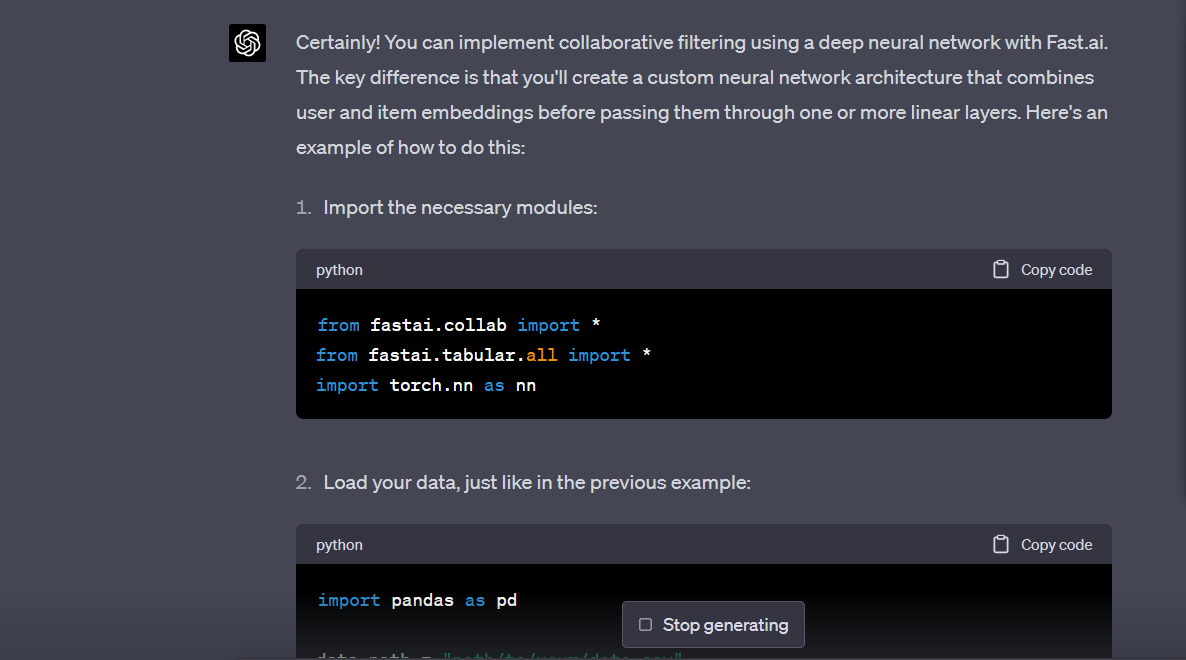

In [ ]:
from fastai.collab import *
from fastai.tabular.all import *
import torch.nn as nn


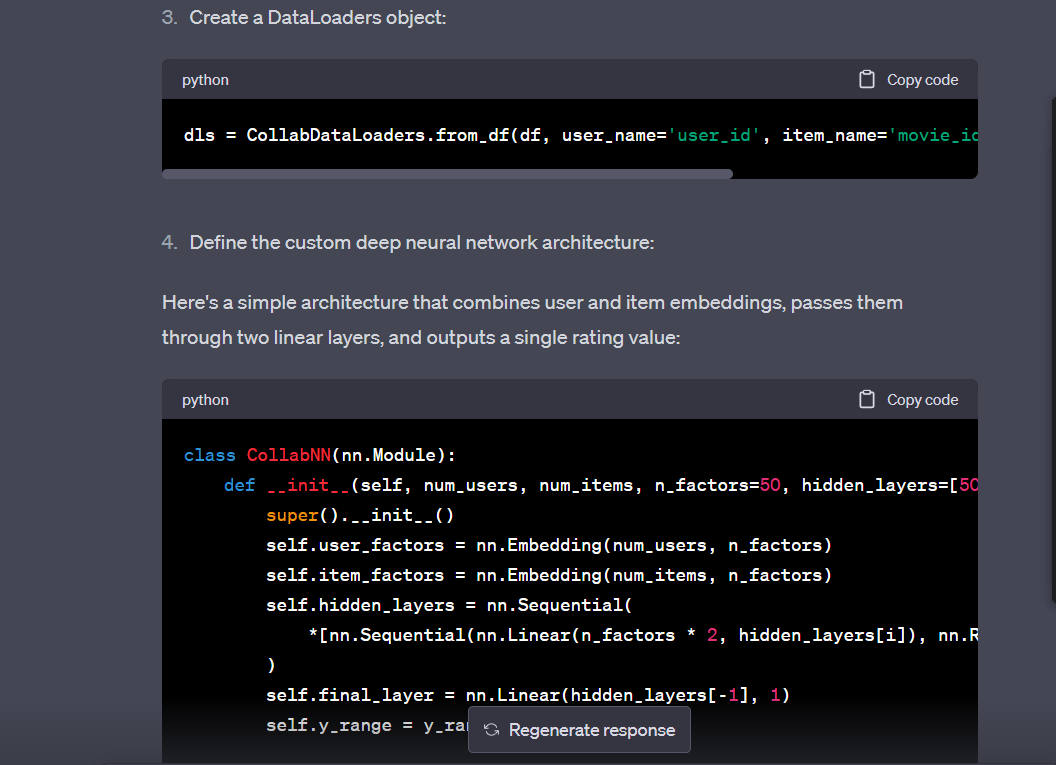

In [ ]:
import pandas as pd

data_path = "path/to/your/data.csv"
df = pd.read_csv(data_path)


In [ ]:
dls = CollabDataLoaders.from_df(df, user_name='user_id', item_name='movie_id', rating_name='rating', bs=64)


In [ ]:
class CollabNN(nn.Module):
    def __init__(self, num_users, num_items, n_factors=50, hidden_layers=[50], y_range=(0, 5.5)):
        super().__init__()
        self.user_factors = nn.Embedding(num_users, n_factors)
        self.item_factors = nn.Embedding(num_items, n_factors)
        self.hidden_layers = nn.Sequential(
            *[nn.Sequential(nn.Linear(n_factors * 2, hidden_layers[i]), nn.ReLU()) for i in range(len(hidden_layers))]
        )
        self.final_layer = nn.Linear(hidden_layers[-1], 1)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:, 0])
        items = self.item_factors(x[:, 1])
        x = torch.cat([users, items], dim=1)
        x = self.hidden_layers(x)
        x = self.final_layer(x)
        return torch.sigmoid(x) * (self.y_range[1] - self.y_range[0]) + self.y_range[0]


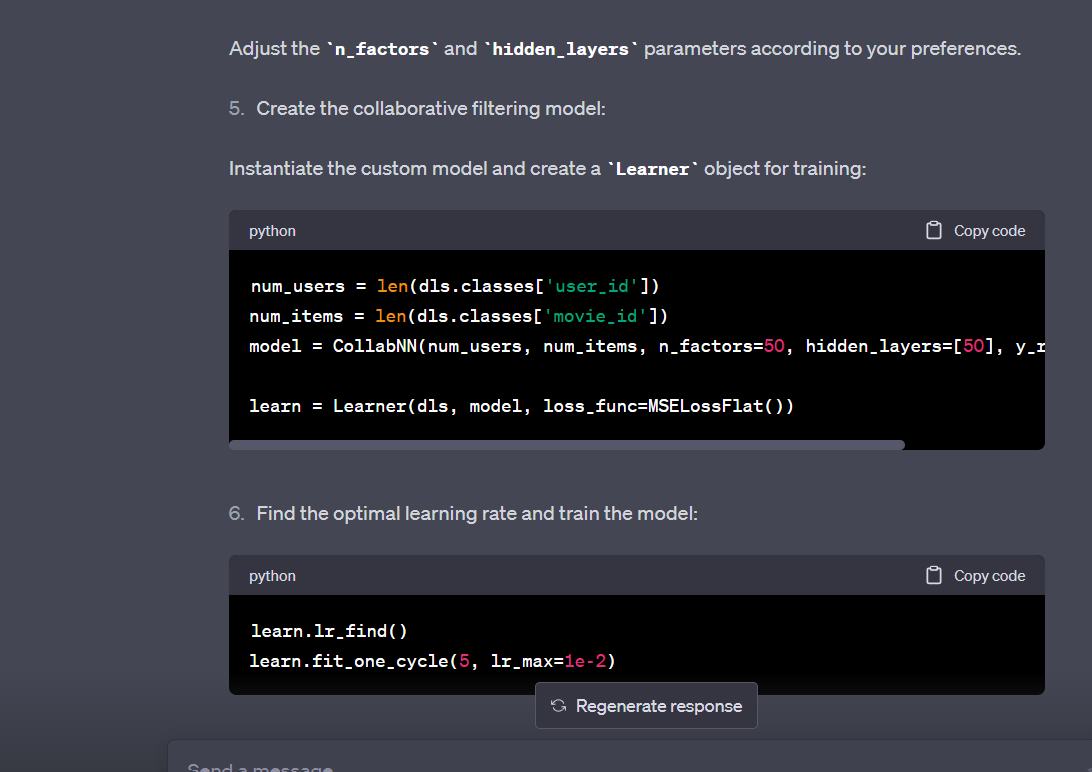

In [ ]:
num_users = len(dls.classes['user_id'])
num_items = len(dls.classes['movie_id'])
model = CollabNN(num_users, num_items, n_factors=50, hidden_layers=[50], y_range=(0, 5.5))

learn = Learner(dls, model, loss_func=MSELossFlat())


In [ ]:
learn.lr_find()
learn.fit_one_cycle(5, lr_max=1e-2)
